In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors
layers = tf.contrib.layers

In [2]:
tf.VERSION

'1.12.0'

In [3]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

In [4]:
## Settings

In [5]:
DTYPE=tf.float32
NP_DTYPE=np.float32
TARGET_DENSITY = 'GOALBAB'
FREQ = 10

# dataset-specific settings
settings = {
    'GOALBAB': {
    'batch_size': 100,
    'num_bijectors': 4,
    'train_iters': 2e4
    }
}

In [6]:
# Load the data
file_path = os.getcwd() + f'/data/freq{FREQ}/goal-babbling/'
file_name = f'goals_and_positions_freq-{FREQ}.npz'
pos_action_noise = np.load(file_path + file_name)
sampled_goals = pos_action_noise['positions']
search_space = pos_action_noise['goals']

(0.0, 0.3)

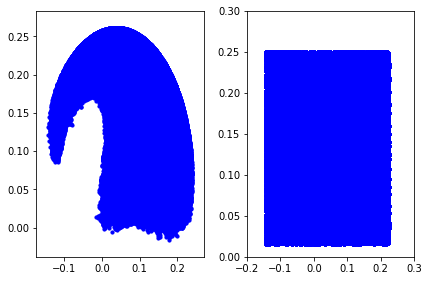

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
xlim, ylim = [-0.2, 0.3], [-0.1, 0.3]
ax1.scatter(sampled_goals[:, 0], sampled_goals[:, 1], s=10, color='blue')
xlim, ylim = [-0.2, 0.3], [0.0, 0.3]
ax2.scatter(search_space[:, 0], search_space[:, 1], s=10, color='blue')

plt.tight_layout()
plt.xlim(xlim)
plt.ylim(ylim)

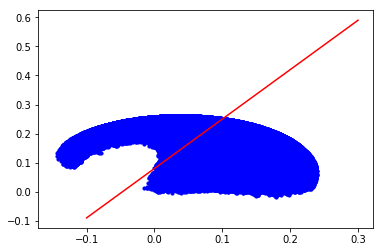

In [8]:
x = np.linspace(-0.1,0.3,100)
y = 1.7*x+0.08
xlim, ylim = [-0.2, 0.3], [-0.1, 0.3]
plt.scatter(sampled_goals[:, 0], sampled_goals[:, 1], s=10, color='blue')
plt.plot(x, y, '-r', label='y=2x+1')

In [9]:
half_A = []
y_line_eq = lambda x : 1.7*x + 0.08

half_A = np.asarray([[point[0], point[1]] for point in sampled_goals if point[1] > y_line_eq(point[0])])
print('A cluster size : ', half_A.shape)
half_B = np.asarray([[point[0], point[1]] for point in sampled_goals if point[1] < y_line_eq(point[0])])
print('B cluster size : ', half_B.shape)

A cluster size :  (139233, 2)
B cluster size :  (260767, 2)


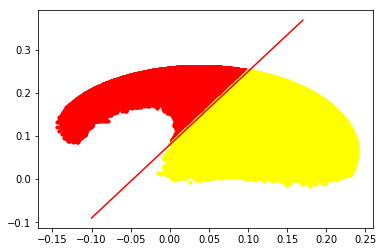

In [10]:
x = np.linspace(-0.1,0.17,100)
y = 1.7*x+0.08
xlim, ylim = [-0.2, 0.3], [-0.1, 0.3]

plt.scatter(half_A[:, 0], half_A[:, 1], s=10, color='red')
plt.scatter(half_B[:, 0], half_B[:, 1], s=10, color='yellow')
plt.plot(x, y, '-r', label='y=2x+1')

In [11]:
c_samples = 5000
region_C = np.asarray([[random.uniform(-0.02, 0.1), random.uniform(0.1, 0.3)] for n in range(c_samples)])

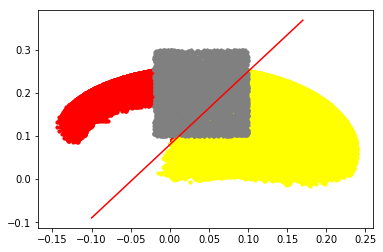

In [12]:
plt.scatter(half_A[:, 0], half_A[:, 1], s=10, color='red')
plt.scatter(half_B[:, 0], half_B[:, 1], s=10, color='yellow')
plt.scatter(region_C[:, 0], region_C[:, 1], s=10, color='gray')
plt.plot(x, y, '-r', label='y=2x+1')

In [13]:
##############
# Training D.A
##############
dataset = tf.data.Dataset.from_tensor_slices(half_A.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=half_A.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()


base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):

    bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))


dist_A = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

# visualization
x = base_dist.sample(8000)
samples_A = [x]
names = [base_dist.name]
for bijector in reversed(dist_A.bijector.bijectors):
    x = bijector.forward(x)
    samples_A.append(x)
    names.append(bijector.name)
    

loss_A = -tf.reduce_mean(dist_A.log_prob(x_samples))
train_op_A = tf.train.AdamOptimizer(1e-4).minimize(loss_A)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

In [14]:
##############
# Training D.B
##############
dataset = tf.data.Dataset.from_tensor_slices(half_B.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=half_B.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):

    bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

dist_B = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

# visualization
x = base_dist.sample(8000)
samples_B = [x]
names = [base_dist.name]
for bijector in reversed(dist_B.bijector.bijectors):
    x = bijector.forward(x)
    samples_B.append(x)
    names.append(bijector.name)
    
loss_B = -tf.reduce_mean(dist_B.log_prob(x_samples))
train_op_B = tf.train.AdamOptimizer(1e-4).minimize(loss_B)



 0 1.8602097

 10000 -3.8823173


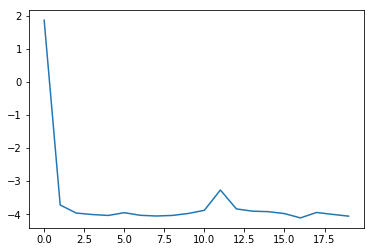

In [15]:
sess.run(tf.global_variables_initializer())

NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op_A, loss_A])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print('\n', i, np_loss)
start = 0
plt.plot(np_losses[start:])



 0 1.8520267

 10000 -3.0280306


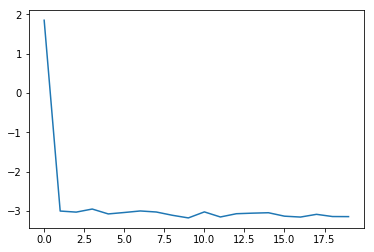

In [16]:
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op_B, loss_B])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print('\n', i, np_loss)
start = 0
plt.plot(np_losses[start:])


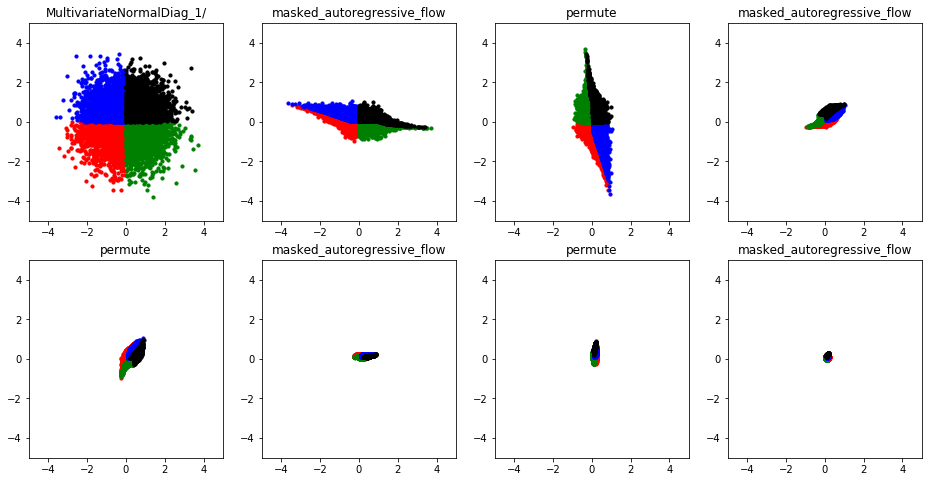

In [17]:
results = sess.run(samples_B)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('trained_bijectors.png', dpi=300)

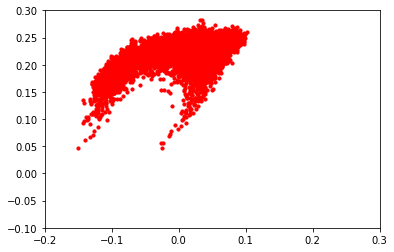

In [22]:
new_samples_A = sess.run(dist_A.sample(5000))
plt.xlim(xlim)
plt.ylim(ylim)
plt.scatter(new_samples_A[:,0], new_samples_A[:, 1], s=10, color='red')

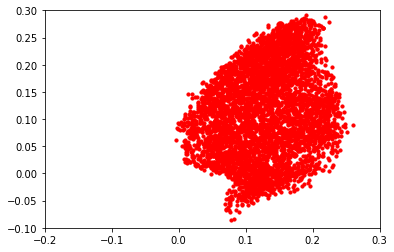

In [23]:
new_samples_B = sess.run(dist_B.sample(5000))
plt.xlim(xlim)
plt.ylim(ylim)
plt.scatter(new_samples_B[:,0], new_samples_B[:, 1], s=10, color='red')

[-5.       -5.       -5.       ...  4.481833  4.481833  4.481833]


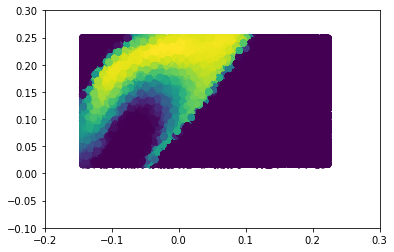

In [20]:
eval_probs = dist_A.prob(search_space)
scale = 5.0
potential_weight = 3.0
potential = tf.log(eval_probs + tf.exp(-scale))

eval_ps = sess.run(potential)
print(eval_ps)
xlim, ylim = [-0.2, 0.3], [-0.1, 0.3]
plt.xlim(xlim)
plt.ylim(ylim)
plt.scatter(search_space[:, 0], search_space[:, 1],
            c=np.squeeze(eval_ps))
plt.savefig('search_space_probs_A.png', dpi=300)

[ 2.9563541  2.9563541  2.9563541 ... -5.        -5.        -5.       ]


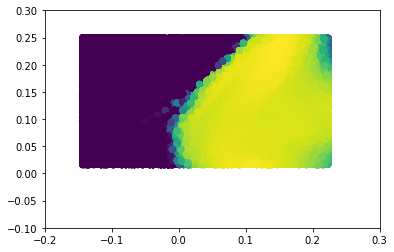

In [21]:
eval_probs = dist_B.prob(search_space)
scale = 5.0
potential_weight = 3.0
potential = tf.log(eval_probs + tf.exp(-scale))

eval_ps = sess.run(potential)
print(eval_ps)
xlim, ylim = [-0.2, 0.3], [-0.1, 0.3]
plt.xlim(xlim)
plt.ylim(ylim)
plt.scatter(search_space[:, 0], search_space[:, 1],
            c=np.squeeze(eval_ps))
plt.savefig('search_space_probs_B.png', dpi=300)